In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [35]:
df_ks = pd.read_csv("./data/ks-projects-201801.csv", encoding='cp932')[['category', 'deadline', 'currency', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']]

# stateの値がsuccessfulなら1(True)，そうでなければ0(False)に変更
df_ks['state'] = df_ks['state'] == 'successful' 

# 先程と似た中古住宅のデータ
display(df_ks.head())
df_ks.describe()

C:\Users\matsumoto sairi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,category,deadline,currency,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,Poetry,2015/10/9,GBP,1000,2015/8/11 12:12,0,False,0,GB,0,0,1533.95
1,Narrative Film,2017/11/1,USD,30000,2017/9/2 4:43,2421,False,15,US,100,2421,30000.00
2,Narrative Film,2013/2/26,USD,45000,2013/1/12 0:20,220,False,3,US,220,220,45000.00
3,Music,2012/4/16,USD,5000,2012/3/17 3:24,1,False,1,US,1,1,5000.00
4,Film & Video,2015/8/29,USD,19500,2015/7/4 8:35,1283,False,14,US,1283,1283,19500.00


,usd_goal_real
count,3.783900e+05
mean,4.546683e+04
std,1.153352e+06
min,0.000000e+00
25%,2.000000e+03
50%,5.500000e+03
75%,1.550000e+04
max,1.663614e+08


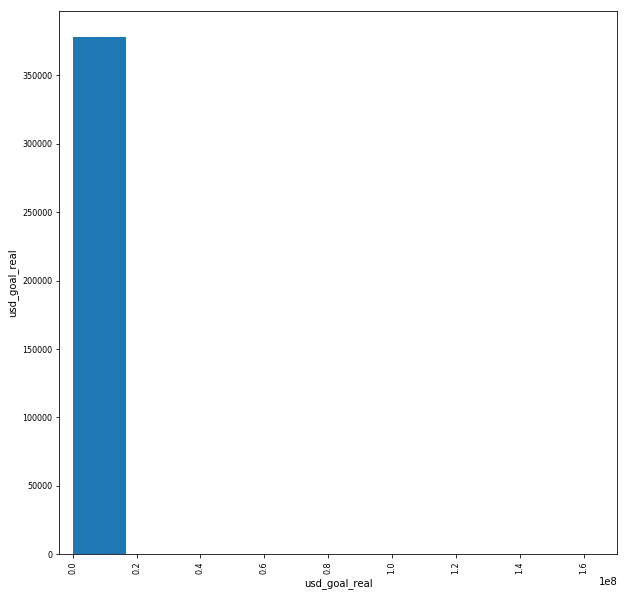

In [29]:
# 散布図行列を書いてみる
pd.plotting.scatter_matrix(df_ks, figsize=(10,10))
plt.show()

In [23]:
df_ks.corr()

,usd_goal_real
usd_goal_real,1.0


In [34]:
# 線形回帰のときと同様に説明変数を2つに絞って，ロジスティック回帰
y = df_ks["state"].values
X = df_ks[["usd_goal_real"]].values

# 各特徴量を平均0，分散1となるような前処理（標準化，詳しくはDAY2にて）を施すためのクラス
# 今回のデータセットは特徴量の平均や分散がそれぞれで大きく異なるため， 確率値がうまく算出されないことが事前検証でわかっている
std_scaler = StandardScaler() 

# fit_transform関数で標準化した特徴量X_scaledを得る
# 以降はX_scaledをモデルの学習等に使う
X_scaled = std_scaler.fit_transform(X)

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X_scaled, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
x1 = X_scaled[:,0] # 標準化されたAreaSize
x2 = X_scaled[:,1] # 標準化されたTrain

# データをプロット
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')

plt.plot(x1[y], x2[y], 'o', color='C0', label='Price >= 20 million')
plt.plot(x1[~y], x2[~y], '^', color='C1', label='Price < 20 million')

# 境界線をプロットして表示
# 紫：境界線
line_x = np.arange(np.min(x1) - 1, np.max(x1) + 1)
line_y = - line_x * w1 / w2 - w0 / w2
plt.plot(line_x, line_y, linestyle='-.', linewidth=3, color='purple', label='Threshold')
plt.ylim([np.min(x2) - 1, np.max(x2) + 1])
plt.legend(loc='best')

plt.xlabel("Scaled AreaSize")
plt.ylabel("Scaled Train")
plt.show()

In [ ]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
# log_lossは「負の」対数尤度を計算する関数であるため， - をつけて戻している
# normalizeという引数をTrueのままにしておくと、合計の対数尤度ではなく平均の対数尤度が計算されるので注意
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est))) 

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

In [ ]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)
#"_"は使わないことを意思表示

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))

In [ ]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 2000万未満', '正解 = 2000万以上'], 
                        columns=['予測 = 2000万未満', '予測 = 2000万以上'])
conf_mat